# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/ensemble/unetr"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/ensemble/unetr


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"data/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR09fold3.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                       | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 97]), label shape: torch.Size([1, 250, 176, 97])


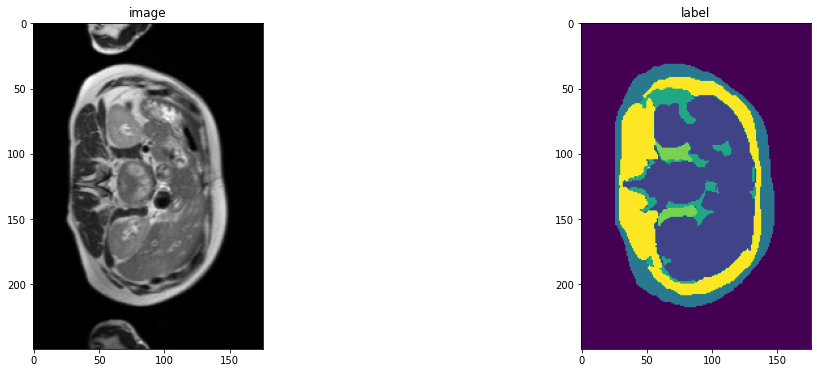

In [7]:
slice_map = {
    "A013_v1_T2W.nii.gz": 10,
    "A013_v1_T2W.nii.gz": 8,
    "A013_v1_T2W.nii.gz": 6
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR10_swinUNetR_fold3.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold3.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=1.85662):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5242369572321574 Current Avg. Dice: 0.5242369572321574


Training (500 / 70000 Steps) (loss=1.48108):  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [00:12<00:07,  2.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5849830309549967 Current Avg. Dice: 0.5849830309549967


Training (750 / 70000 Steps) (loss=1.47716):  58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [00:11<00:12,  2.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.621090809504191 Current Avg. Dice: 0.621090809504191


Training (1000 / 70000 Steps) (loss=1.16145):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.637324333190918 Current Avg. Dice: 0.637324333190918


Training (1250 / 70000 Steps) (loss=1.70814):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6506505211194357 Current Avg. Dice: 0.6506505211194357


Training (1500 / 70000 Steps) (loss=0.96974):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:16,  6.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.664626955986023 Current Avg. Dice: 0.664626955986023


Training (1750 / 70000 Steps) (loss=0.95392):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6697314580281576 Current Avg. Dice: 0.6697314580281576


Training (2000 / 70000 Steps) (loss=0.93695):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6745407581329346 Current Avg. Dice: 0.6745407581329346


Training (2250 / 70000 Steps) (loss=0.95080):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6823288997014364 Current Avg. Dice: 0.6823288997014364


Training (2500 / 70000 Steps) (loss=0.68190):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6823288997014364 Current Avg. Dice: 0.6754620472590128


Training (2750 / 70000 Steps) (loss=0.74875):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6823288997014364 Current Avg. Dice: 0.6780762473742167


Training (3000 / 70000 Steps) (loss=0.66004):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:10,  6.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6823288997014364 Current Avg. Dice: 0.6698833306630453


Training (3250 / 70000 Steps) (loss=0.78740):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6872904300689697 Current Avg. Dice: 0.6872904300689697


Training (3500 / 70000 Steps) (loss=0.62020):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:12<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6872904300689697 Current Avg. Dice: 0.6854423880577087


Training (3750 / 70000 Steps) (loss=0.77069):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6882760127385458 Current Avg. Dice: 0.6882760127385458


Training (4000 / 70000 Steps) (loss=0.47184):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.697599450747172 Current Avg. Dice: 0.697599450747172


Training (4250 / 70000 Steps) (loss=0.65327):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.697599450747172 Current Avg. Dice: 0.69097371896108


Training (4500 / 70000 Steps) (loss=0.57661):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:14,  6.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7017399072647095 Current Avg. Dice: 0.7017399072647095


Training (4750 / 70000 Steps) (loss=0.47047):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7017399072647095 Current Avg. Dice: 0.7009841601053873


Training (5000 / 70000 Steps) (loss=0.99481):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7057743271191915 Current Avg. Dice: 0.7057743271191915


Training (5250 / 70000 Steps) (loss=0.47454):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7057743271191915 Current Avg. Dice: 0.7002956668535868


Training (5500 / 70000 Steps) (loss=0.55268):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7057743271191915 Current Avg. Dice: 0.7043464382489523


Training (5750 / 70000 Steps) (loss=0.42574):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:28,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7057743271191915 Current Avg. Dice: 0.6985945701599121


Training (6000 / 70000 Steps) (loss=0.52455):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:13,  6.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7057743271191915 Current Avg. Dice: 0.6994331479072571


Training (6250 / 70000 Steps) (loss=0.58970):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7093199094136556 Current Avg. Dice: 0.7093199094136556


Training (6500 / 70000 Steps) (loss=0.56590):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7093199094136556 Current Avg. Dice: 0.699909488360087


Training (6750 / 70000 Steps) (loss=0.63118):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7093199094136556 Current Avg. Dice: 0.7069290081659952


Training (7000 / 70000 Steps) (loss=0.50825):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:10<00:18,  2.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7117633819580078 Current Avg. Dice: 0.7117633819580078


Training (7250 / 70000 Steps) (loss=0.50989):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7117633819580078 Current Avg. Dice: 0.7043506503105164


Training (7500 / 70000 Steps) (loss=0.51101):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:14,  6.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7170597314834595 Current Avg. Dice: 0.7170597314834595


Training (7750 / 70000 Steps) (loss=0.50193):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8014099597930908 Current Avg. Dice: 0.8014099597930908


Training (8000 / 70000 Steps) (loss=0.50628):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8137710491816202 Current Avg. Dice: 0.8137710491816202


Training (8250 / 70000 Steps) (loss=0.46135):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8271463910738627 Current Avg. Dice: 0.8271463910738627


Training (8500 / 70000 Steps) (loss=0.37219):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271463910738627 Current Avg. Dice: 0.8181774218877157


Training (8750 / 70000 Steps) (loss=0.51716):  25%|████████████████████████████▌                                                                                     | 3/12 [00:08<00:29,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271463910738627 Current Avg. Dice: 0.824520985285441


Training (9000 / 70000 Steps) (loss=0.51795):   8%|█████████▌                                                                                                        | 1/12 [00:06<01:12,  6.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271463910738627 Current Avg. Dice: 0.8256931900978088


Training (9250 / 70000 Steps) (loss=0.42375):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:14<00:02,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8308492104212443 Current Avg. Dice: 0.8308492104212443


Training (9500 / 70000 Steps) (loss=0.55834):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:12<00:07,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8351807196935018


Training (9750 / 70000 Steps) (loss=0.38075):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:11<00:12,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8281667033831278


Training (10000 / 70000 Steps) (loss=0.36379):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8271545767784119


Training (10250 / 70000 Steps) (loss=0.58346):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8331369956334432


Training (10500 / 70000 Steps) (loss=0.46294):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8274420499801636


Training (10750 / 70000 Steps) (loss=0.55282):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8178584376970927


Training (11000 / 70000 Steps) (loss=0.39118):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8349054257074991


Training (11250 / 70000 Steps) (loss=0.58512):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8302722771962484


Training (11500 / 70000 Steps) (loss=0.46388):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8270783027013143


Training (11750 / 70000 Steps) (loss=0.37343):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.833491325378418


Training (12000 / 70000 Steps) (loss=0.46315):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.831109901269277


Training (12250 / 70000 Steps) (loss=0.36490):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.8297161857287089


Training (12500 / 70000 Steps) (loss=0.48662):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8351807196935018 Current Avg. Dice: 0.829783300558726


Training (12750 / 70000 Steps) (loss=0.38373):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8373159368832906 Current Avg. Dice: 0.8373159368832906


Training (13000 / 70000 Steps) (loss=0.39162):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8383342425028483


Training (13250 / 70000 Steps) (loss=0.33349):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8328201770782471


Training (13500 / 70000 Steps) (loss=0.35718):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8307799696922302


Training (13750 / 70000 Steps) (loss=0.50109):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8305096427599589


Training (14000 / 70000 Steps) (loss=0.26931):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8357049425443014


Training (14250 / 70000 Steps) (loss=0.30067):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8383342425028483 Current Avg. Dice: 0.8369500438372294


Training (14500 / 70000 Steps) (loss=0.33168):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8392029205958048 Current Avg. Dice: 0.8392029205958048


Training (14750 / 70000 Steps) (loss=0.56277):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8392029205958048 Current Avg. Dice: 0.8353979786237081


Training (15000 / 70000 Steps) (loss=0.44945):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8392029205958048 Current Avg. Dice: 0.8346150318781534


Training (15250 / 70000 Steps) (loss=0.37236):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8392029205958048 Current Avg. Dice: 0.8379681905110677


Training (15500 / 70000 Steps) (loss=0.49115):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8399061957995096 Current Avg. Dice: 0.8399061957995096


Training (15750 / 70000 Steps) (loss=0.32237):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8399061957995096 Current Avg. Dice: 0.8344516754150391


Training (16000 / 70000 Steps) (loss=0.39943):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8399061957995096 Current Avg. Dice: 0.8378780682881674


Training (16250 / 70000 Steps) (loss=0.33950):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8425979018211365


Training (16500 / 70000 Steps) (loss=0.24769):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.834071139494578


Training (16750 / 70000 Steps) (loss=0.52204):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8413139581680298


Training (17000 / 70000 Steps) (loss=0.35920):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8409881790479025


Training (17250 / 70000 Steps) (loss=0.45711):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8237579067548116


Training (17500 / 70000 Steps) (loss=0.40584):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8350595831871033


Training (17750 / 70000 Steps) (loss=0.59358):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8425979018211365 Current Avg. Dice: 0.8353680968284607


Training (18000 / 70000 Steps) (loss=0.37813):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8445456624031067


Training (18250 / 70000 Steps) (loss=0.22243):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8417553504308065


Training (18500 / 70000 Steps) (loss=0.33659):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8399841785430908


Training (18750 / 70000 Steps) (loss=0.21892):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8416570425033569


Training (19000 / 70000 Steps) (loss=0.59246):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8399262626965841


Training (19250 / 70000 Steps) (loss=0.43685):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8325814803441366


Training (19500 / 70000 Steps) (loss=0.31339):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8396364053090414


Training (19750 / 70000 Steps) (loss=0.40329):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8329186042149862


Training (20000 / 70000 Steps) (loss=0.34236):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8399532238642374


Training (20250 / 70000 Steps) (loss=0.45535):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.842625359694163


Training (20500 / 70000 Steps) (loss=0.38765):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:18,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8445456624031067 Current Avg. Dice: 0.8379166126251221


Training (20750 / 70000 Steps) (loss=0.25136):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8470542232195536


Training (21000 / 70000 Steps) (loss=0.49294):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8410293857256571


Training (21250 / 70000 Steps) (loss=0.27923):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8331640362739563


Training (21500 / 70000 Steps) (loss=0.54959):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8400403261184692


Training (21750 / 70000 Steps) (loss=0.37049):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8408790628115336


Training (22000 / 70000 Steps) (loss=0.43987):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8450997471809387


Training (22250 / 70000 Steps) (loss=0.46247):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8454509377479553


Training (22500 / 70000 Steps) (loss=0.29308):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8415414293607076


Training (22750 / 70000 Steps) (loss=0.37199):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8448453744252523


Training (23000 / 70000 Steps) (loss=0.31942):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8441463311513265


Training (23250 / 70000 Steps) (loss=0.41967):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8413709799448649


Training (23500 / 70000 Steps) (loss=0.37364):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8414472738901774


Training (23750 / 70000 Steps) (loss=0.30227):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8354425430297852


Training (23906 / 70000 Steps) (loss=0.30321):  25%|████████████████████████████▎                                                                                    | 3/12 [00:03<00:09,  1.03s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (26250 / 70000 Steps) (loss=0.48736):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8470542232195536 Current Avg. Dice: 0.8425524632136027


Training (26500 / 70000 Steps) (loss=0.45676):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8477293848991394


Training (26750 / 70000 Steps) (loss=0.28988):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.837008555730184


Training (27000 / 70000 Steps) (loss=0.23426):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8445334235827128


Training (27250 / 70000 Steps) (loss=0.43994):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8366326292355856


Training (27500 / 70000 Steps) (loss=0.26899):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8408858378728231


Training (27750 / 70000 Steps) (loss=0.23528):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.83975750207901


Training (28000 / 70000 Steps) (loss=0.33726):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8420802553494772


Training (28500 / 70000 Steps) (loss=0.47428):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8454579909642538


Training (28750 / 70000 Steps) (loss=0.34720):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8474807341893514


Training (29000 / 70000 Steps) (loss=0.34709):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8477293848991394 Current Avg. Dice: 0.8380113442738851


Training (29250 / 70000 Steps) (loss=0.60575):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8490438461303711 Current Avg. Dice: 0.8490438461303711


Training (29500 / 70000 Steps) (loss=0.49668):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8490438461303711 Current Avg. Dice: 0.8434053858121237


Training (29571 / 70000 Steps) (loss=0.26937):  33%|█████████████████████████████████████▋                                                                           | 4/12 [00:04<00:07,  1.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (36000 / 70000 Steps) (loss=0.14579):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8522428472836813 Current Avg. Dice: 0.8436481157938639


Training (36250 / 70000 Steps) (loss=0.32236):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8523424665133158


Training (36500 / 70000 Steps) (loss=0.33720):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8440229694048563


Training (36750 / 70000 Steps) (loss=0.30990):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8473550081253052


Training (37000 / 70000 Steps) (loss=0.31316):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8476347327232361


Training (37250 / 70000 Steps) (loss=0.29445):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8446305990219116


Training (37500 / 70000 Steps) (loss=0.34129):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.851184626420339


Training (37750 / 70000 Steps) (loss=0.17705):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8446138501167297


Training (38000 / 70000 Steps) (loss=0.33536):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8459816972414652


Training (38250 / 70000 Steps) (loss=0.38009):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8499347567558289


Training (38500 / 70000 Steps) (loss=0.40401):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8487956722577413


Training (38750 / 70000 Steps) (loss=0.28049):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8449136217435201


Training (39000 / 70000 Steps) (loss=0.22097):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8508037130037943


Training (39250 / 70000 Steps) (loss=0.21682):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8508614301681519


Training (39500 / 70000 Steps) (loss=0.34102):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8466380834579468


Training (39750 / 70000 Steps) (loss=0.36959):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8491727511088053


Training (40000 / 70000 Steps) (loss=0.26438):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8461068272590637


Training (40250 / 70000 Steps) (loss=0.33140):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8509920636812845


Training (40500 / 70000 Steps) (loss=0.23953):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8451965053876241


Training (40750 / 70000 Steps) (loss=0.30098):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8502811789512634


Training (41000 / 70000 Steps) (loss=0.37181):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8419796824455261


Training (41250 / 70000 Steps) (loss=0.37816):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8509193460146586


Training (41500 / 70000 Steps) (loss=0.26447):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8477101723353068


Training (41750 / 70000 Steps) (loss=0.35187):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:30,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8467499017715454


Training (42000 / 70000 Steps) (loss=0.29403):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523424665133158 Current Avg. Dice: 0.8508428931236267


Training (42250 / 70000 Steps) (loss=0.24592):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8523749113082886


Training (42500 / 70000 Steps) (loss=0.28301):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8474403421084086


Training (42750 / 70000 Steps) (loss=0.38908):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8470842639605204


Training (43000 / 70000 Steps) (loss=0.31629):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8492593566576639


Training (43250 / 70000 Steps) (loss=0.33259):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8415065407752991


Training (43500 / 70000 Steps) (loss=0.28933):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8496654431025187


Training (43750 / 70000 Steps) (loss=0.25723):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8424696326255798


Training (44000 / 70000 Steps) (loss=0.27871):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8523749113082886 Current Avg. Dice: 0.8464831908543905


Training (44250 / 70000 Steps) (loss=0.23295):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8530460993448893


Training (44500 / 70000 Steps) (loss=0.26757):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8459425767262777


Training (44750 / 70000 Steps) (loss=0.41844):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8502400517463684


Training (45000 / 70000 Steps) (loss=0.28099):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8526371518770853


Training (45250 / 70000 Steps) (loss=0.36168):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8473774989446005


Training (45500 / 70000 Steps) (loss=0.35519):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.848412295182546


Training (45750 / 70000 Steps) (loss=0.49397):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8512306213378906


Training (46000 / 70000 Steps) (loss=0.29996):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8445907632509867


Training (46250 / 70000 Steps) (loss=0.39836):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:30,  3.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8525119225184122


Training (46500 / 70000 Steps) (loss=0.20766):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8505609035491943


Training (46750 / 70000 Steps) (loss=0.31531):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.843987246354421


Training (47000 / 70000 Steps) (loss=0.31298):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8502029577891032


Training (47250 / 70000 Steps) (loss=0.22696):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8473229805628458


Training (47500 / 70000 Steps) (loss=0.34499):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8450300494829813


Training (47750 / 70000 Steps) (loss=0.19518):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8431243499120077


Training (48000 / 70000 Steps) (loss=0.24632):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8467869559923807


Training (48250 / 70000 Steps) (loss=0.31320):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8469710946083069


Training (48500 / 70000 Steps) (loss=0.26233):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8427470525105795


Training (48750 / 70000 Steps) (loss=0.28183):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.837683359781901


Training (49000 / 70000 Steps) (loss=0.28737):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8461176951726278


Training (49250 / 70000 Steps) (loss=0.30326):  25%|████████████████████████████▎                                                                                    | 3/12 [00:07<00:28,  3.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8453704913457235


Training (49500 / 70000 Steps) (loss=0.30446):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8435162703196207


Training (49750 / 70000 Steps) (loss=0.25972):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8459106087684631


Training (50000 / 70000 Steps) (loss=0.23387):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8512287537256876


Training (50250 / 70000 Steps) (loss=0.29291):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8516944845517477


Training (50500 / 70000 Steps) (loss=0.17291):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8477718035380045


Training (50750 / 70000 Steps) (loss=0.27646):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8420806328455607


Training (51000 / 70000 Steps) (loss=0.23845):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8454121351242065


Training (51250 / 70000 Steps) (loss=0.30144):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8506790399551392


Training (51500 / 70000 Steps) (loss=0.21131):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8445820411046346


Training (51750 / 70000 Steps) (loss=0.32042):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8493369221687317


Training (52000 / 70000 Steps) (loss=0.33158):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8477310339609782


Training (52250 / 70000 Steps) (loss=0.28378):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8434395988782247


Training (52500 / 70000 Steps) (loss=0.21900):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.844514270623525


Training (52750 / 70000 Steps) (loss=0.27578):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8499474922815958


Training (53000 / 70000 Steps) (loss=0.13926):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:06,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8493266900380453


Training (53250 / 70000 Steps) (loss=0.30727):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8459200064341227


Training (53500 / 70000 Steps) (loss=0.34097):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8474457859992981


Training (53750 / 70000 Steps) (loss=0.25908):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8454833030700684


Training (54000 / 70000 Steps) (loss=0.30314):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:09,  6.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8500033219655355


Training (54250 / 70000 Steps) (loss=0.35333):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8523703614870707


Training (54500 / 70000 Steps) (loss=0.28406):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8448054194450378


Training (54750 / 70000 Steps) (loss=0.28541):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8503893613815308


Training (55000 / 70000 Steps) (loss=0.36594):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.846079965432485


Training (55250 / 70000 Steps) (loss=0.22783):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8482693831125895


Training (55500 / 70000 Steps) (loss=0.24982):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8485870361328125


Training (55750 / 70000 Steps) (loss=0.29198):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8489108284314474


Training (56000 / 70000 Steps) (loss=0.19245):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8460030754407247


Training (56250 / 70000 Steps) (loss=0.24482):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8464046319325765


Training (56500 / 70000 Steps) (loss=0.21224):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8499510089556376


Training (56750 / 70000 Steps) (loss=0.21432):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8493731220563253


Training (57000 / 70000 Steps) (loss=0.32387):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.842916746934255


Training (57250 / 70000 Steps) (loss=0.28285):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8464020490646362


Training (57500 / 70000 Steps) (loss=0.15298):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8464046716690063


Training (57750 / 70000 Steps) (loss=0.35907):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8447625637054443


Training (58000 / 70000 Steps) (loss=0.26399):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8499136169751486


Training (58250 / 70000 Steps) (loss=0.16110):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.8481625318527222


Training (58500 / 70000 Steps) (loss=0.25532):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8530460993448893 Current Avg. Dice: 0.850598673025767


Training (58750 / 70000 Steps) (loss=0.27931):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8539387583732605 Current Avg. Dice: 0.8539387583732605


Training (59000 / 70000 Steps) (loss=0.26243):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8539387583732605 Current Avg. Dice: 0.8508879343668619


Training (59250 / 70000 Steps) (loss=0.34318):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8539387583732605 Current Avg. Dice: 0.843841552734375


Training (59500 / 70000 Steps) (loss=0.27371):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8539387583732605 Current Avg. Dice: 0.8518851399421692


Training (59750 / 70000 Steps) (loss=0.32761):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8548401991526285


Training (60000 / 70000 Steps) (loss=0.19510):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8445981740951538


Training (60250 / 70000 Steps) (loss=0.25910):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8429695963859558


Training (60500 / 70000 Steps) (loss=0.17882):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8456080953280131


Training (60750 / 70000 Steps) (loss=0.20632):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8499352335929871


Training (61000 / 70000 Steps) (loss=0.26704):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.853045662244161


Training (61250 / 70000 Steps) (loss=0.30259):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8445474704106649


Training (61500 / 70000 Steps) (loss=0.28498):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8501728574434916


Training (61750 / 70000 Steps) (loss=0.28591):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8445173700650533


Training (62000 / 70000 Steps) (loss=0.26803):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8479598760604858


Training (62250 / 70000 Steps) (loss=0.22657):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8426323731740316


Training (62500 / 70000 Steps) (loss=0.26995):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8413821856180826


Training (62750 / 70000 Steps) (loss=0.26701):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8521082003911337


Training (63000 / 70000 Steps) (loss=0.35910):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:11,  6.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8407713174819946


Training (63250 / 70000 Steps) (loss=0.39417):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8492817878723145


Training (63500 / 70000 Steps) (loss=0.31875):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8455424110094706


Training (63750 / 70000 Steps) (loss=0.37072):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8409557739893595


Training (64000 / 70000 Steps) (loss=0.21411):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8427827755610148


Training (64250 / 70000 Steps) (loss=0.31079):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:29,  3.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8487852811813354


Training (64500 / 70000 Steps) (loss=0.31846):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:14,  6.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.845955510934194


Training (64750 / 70000 Steps) (loss=0.32558):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8423569997151693


Training (65000 / 70000 Steps) (loss=0.24683):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8457956115404764


Training (65250 / 70000 Steps) (loss=0.19207):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8358646035194397


Training (65500 / 70000 Steps) (loss=0.32364):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8424516717592875


Training (65750 / 70000 Steps) (loss=0.27175):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8447386622428894


Training (66000 / 70000 Steps) (loss=0.15519):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:10,  6.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8491835594177246


Training (66250 / 70000 Steps) (loss=0.35746):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8457112312316895


Training (66500 / 70000 Steps) (loss=0.23562):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:12<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8403852979342142


Training (66750 / 70000 Steps) (loss=0.23100):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.848625103632609


Training (67000 / 70000 Steps) (loss=0.30257):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8435371120770773


Training (67250 / 70000 Steps) (loss=0.23083):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8467718561490377


Training (67500 / 70000 Steps) (loss=0.26571):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:13,  6.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8475647966066996


Training (67750 / 70000 Steps) (loss=0.33930):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8399584094683329


Training (68000 / 70000 Steps) (loss=0.32520):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8492980400721232


Training (68250 / 70000 Steps) (loss=0.37341):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8414590954780579


Training (68500 / 70000 Steps) (loss=0.25888):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8482847015062968


Training (68750 / 70000 Steps) (loss=0.27232):  25%|████████████████████████████▎                                                                                    | 3/12 [00:08<00:28,  3.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8416256904602051


Training (69000 / 70000 Steps) (loss=0.31689):   8%|█████████▍                                                                                                       | 1/12 [00:06<01:12,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8461742202440897


Training (69250 / 70000 Steps) (loss=0.21807):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:14<00:02,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8471807638804117


Training (69500 / 70000 Steps) (loss=0.25660):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:13<00:07,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8509877721468607


Training (69750 / 70000 Steps) (loss=0.17363):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:11<00:12,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8416989048322042


Training (70000 / 70000 Steps) (loss=0.43488):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:09<00:18,  2.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8548401991526285 Current Avg. Dice: 0.8400052587191263


Training (70007 / 70000 Steps) (loss=0.26331): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.30s/it]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8548 at iteration: 59750


### Plot the loss and metric

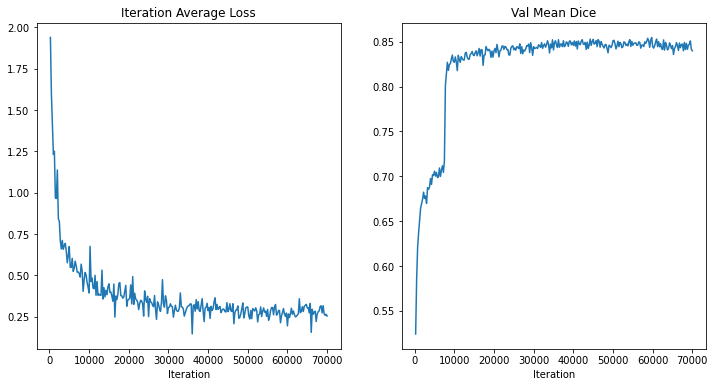

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

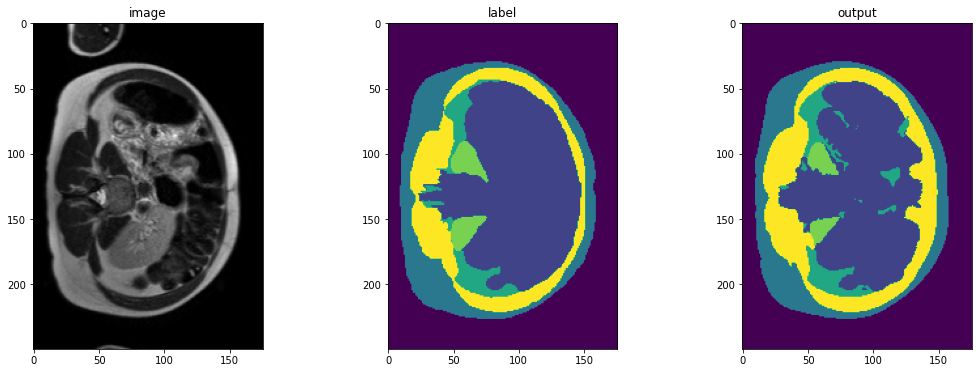

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold3.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [45]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR10swinfold3", output_postfix="seg", resample=False, separate_folder=False),
])

Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


2024-01-16 10:26:27,151 INFO image_writer.py:194 - writing: outMR07_Jan24/A043_v5_T2W_seg.nii.gz


Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]


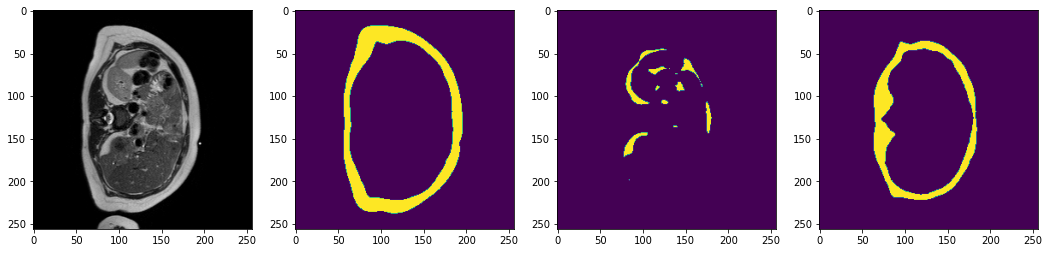

In [47]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR10_swinUNetR_fold3.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [48]:
!tar -cvzf outMR10swinfold3.tar.gz outMR10swinfold3

outMR07_Jan24/
outMR07_Jan24/A026_v1_T2W_seg.nii.gz
outMR07_Jan24/A033_v3_T2W_seg.nii.gz
outMR07_Jan24/A043_v5_T2W_seg.nii.gz
outMR07_Jan24/A051_v2_T2W_seg.nii.gz
outMR07_Jan24/A009_v4_T2W_seg.nii.gz
outMR07_Jan24/A002_v3_T2W_seg.nii.gz
outMR07_Jan24/A029_v4_T2W_seg.nii.gz
outMR07_Jan24/.ipynb_checkpoints/
